# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Capstone Project Model Solution

In this notebook, we provide a model solution to backtest different position sizing techniques. You can refer to this if you are stuck in any step while building your own solution. The features and parameters added here are not exhaustive.

The model solution guides you through answering the problem statement posed in the capstone project. The notebook structure is as follows:

1. [Read Price Data](#read): Get the price data of the ticker of your choice. We have provided sample price data for S&P 500 ETF Trust. We then split this data into 2 subsets. You can choose the length of the subset at your discretion.
<br>

1. [Define Parameters](#params): We analyse the buy and hold strategy returns over one of the subsets. From that we calculate:
$$\text{Multiplier = 1 / Drawdown}$$
$$\text{Volatility target = Average volatility of the returns}$$
<br>

1. [Implement the Techniques on Balance Data](#analysis): We analyse and compare the performance of the following techniques:
    * Volatility Targeting
    * Constant Proportion Portfolio Insurance (CPPI)
    * Time Invariant Portfolio Protection (TIPP)
    * TIPP with Volatility Targeting<br>
    
We select the technique that fits our trading style and risk parameters.
<br>

## Import Libraries

In [1]:
# Import and filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Import custom functions from data_modules
import sys
sys.path.append("..")
from data_modules.capstone_util import performance_analysis, run_vol_targeting, run_cppi, run_tipp, run_tipp_vol

<a id='read'></a> 
## Read Price Data

The daily frequency data for the S&P 500 ETF Trust is stored in the `spy_2000_2021.csv`. The data is from 2000 to 2021. We split the data into 2 parts:
 * **2000 to 2010**: For selecting the multiplier and volatility target
 * **2011 to 2021**: For backtesting the position sizing techniques

In [2]:
# Read the CSV file
path = "../data_modules/"
spy_all = pd.read_csv(path + "spy_2000_2021.csv",
                      index_col=0, parse_dates=True)[['Close']]

# Split the data into two parts
# Data till 2010 is used to select the parameters
spy_2000_2010 = spy_all[:'2010']

# Data from 2011 to 2021 is used to test the techniques
spy_2011_2021 = spy_all['2011':]

# Print head for spy_all
spy_all.head()

,Close
Date,
1999-12-31,98.792610
2000-01-03,97.825676
2000-01-04,94.000107
2000-01-05,94.168259
2000-01-06,92.654861


<a id='params'></a>
## Defining Parameters

1. We take an **initial capital of $10,000**. You can change it as per your choice.
1. We take a **window of 21**. Since we are using daily data, 21 represents the values for rolling one month. You can use a window as per your logic as well.
1. We cap our **maximum leverage to 5**. You can change this value as per your risk appetite.
1. We will take a **floor of 60%**. You can choose this based on your risk appetite. If you are risk averse, please keep this value high.

In [3]:
# Define initial capital
initial_capital = 10000

# Define window
window = 21

# Define leverage cap
leverage_cap = 5

# Floor percentage level for TIPP, CPPI, TIPP with volatility targeting
floor_percent = 0.6

### Defining Multiplier and Volatility Target

In [4]:
# Calculate daily strategy returns
spy_2000_2010['benchmark_returns'] = spy_2000_2010['Close'].pct_change()
spy_2000_2010.dropna(inplace=True)

# Calculate cumulative returns
spy_2000_2010['cumulative_returns'] = (
    1 + spy_2000_2010['benchmark_returns']).cumprod()

# Drawdown
drawdown = abs(min(
    (spy_2000_2010['cumulative_returns'] / np.maximum.accumulate(spy_2000_2010['cumulative_returns']) - 1)))

# Defining multiplier
multiplier = (1 / drawdown)

# Defining volatility target
volatility_target = spy_2000_2010['benchmark_returns'].rolling(
    window=window).std().mean()

# Print volatility target and multiplier
print(f"Multiplier: {multiplier:.2f}")
print(f"Volatility target: {volatility_target:.2f}")

Multiplier: 1.81
Volatility target: 0.01


<a id='analysis'></a>
## Implementing the Techniques on Balance Data
We will be running our techniques on `spy_2011_2021`.

### Analysing Volatility Targeting

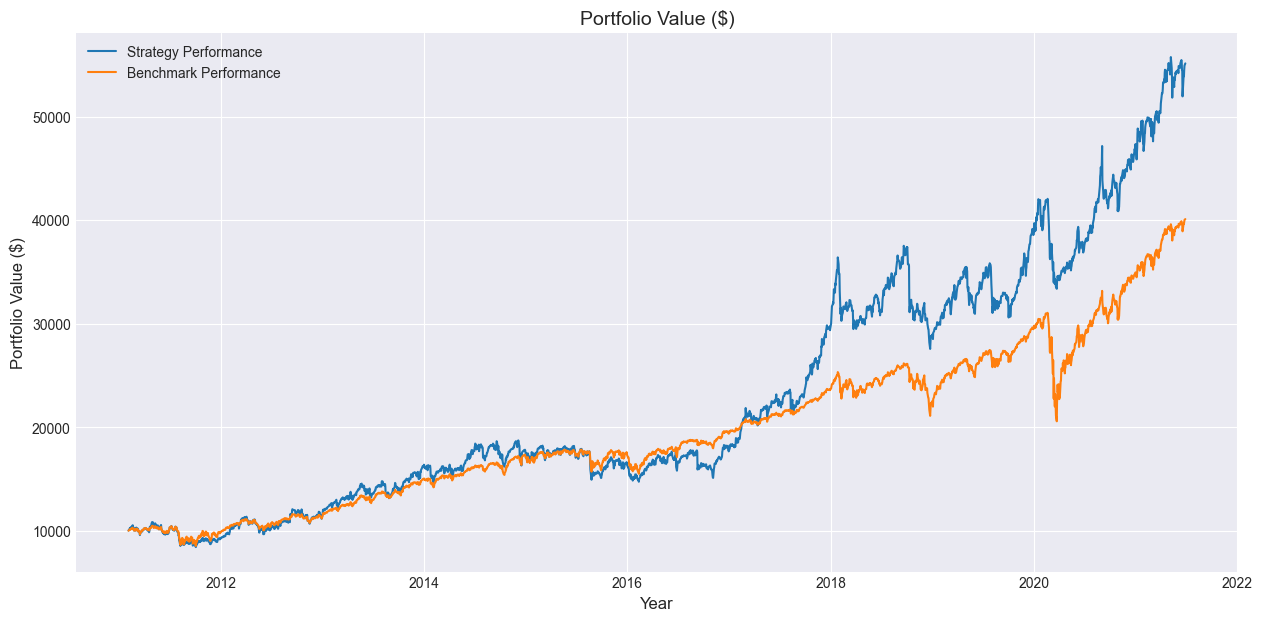

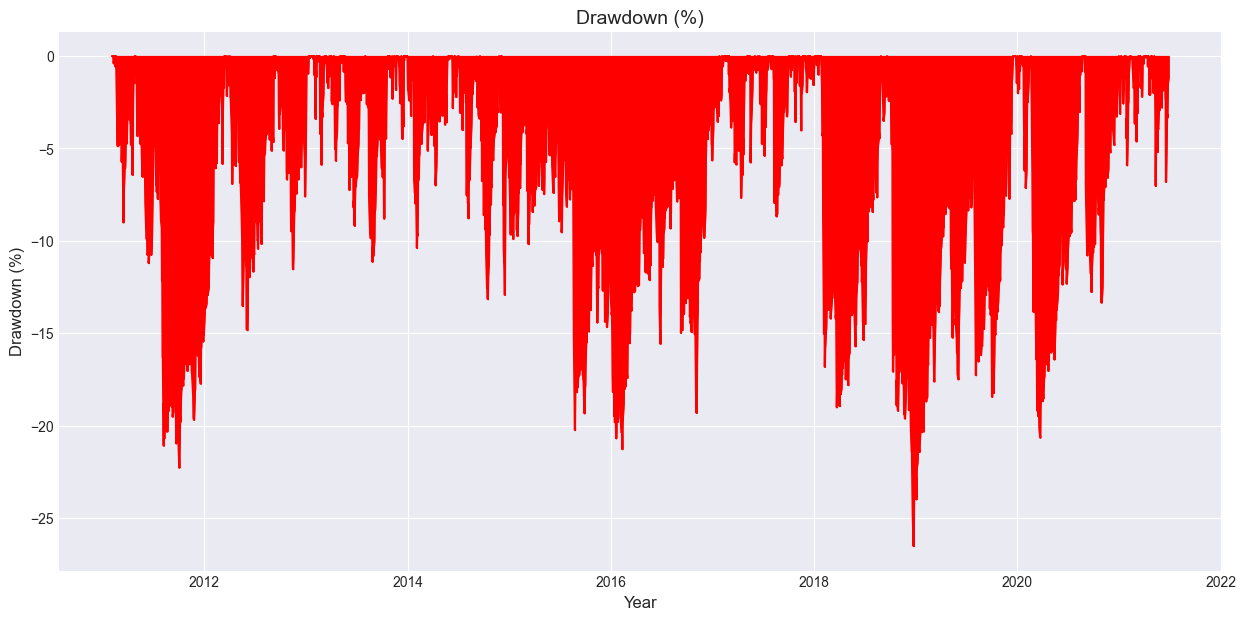

Total returns: 451.33%
Annualised returns (CAGR): 17.87%
Maximum drawdown (MDD): -26.52%
Return-to-MDD ratio: 0.67
Sharpe ratio: 0.06


In [5]:
# Run volatility targeting technique
returns_vol_targeting = run_vol_targeting(spy_2011_2021,
                                          volatility_target=volatility_target,
                                          window=window,
                                          leverage_cap=leverage_cap,
                                          initial_capital=initial_capital)

# Check strategy performance
performance_analysis(returns_vol_targeting, initial_capital)

### Analysing CPPI

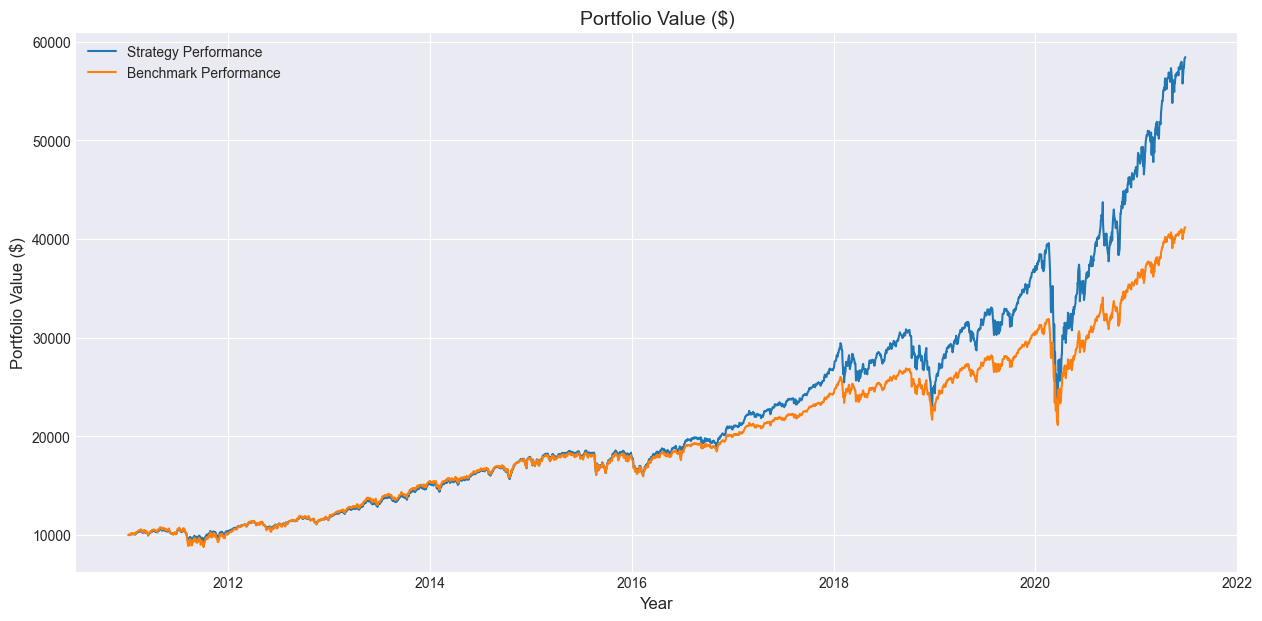

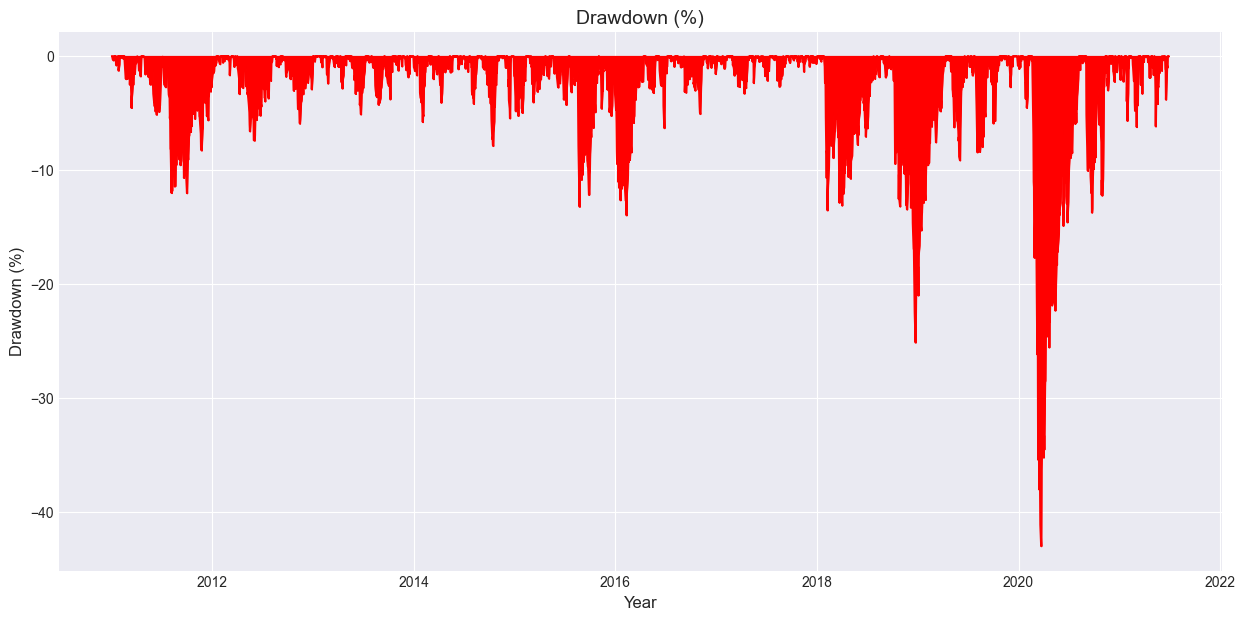

Total returns: 484.33%
Annualised returns (CAGR): 18.37%
Maximum drawdown (MDD): -42.98%
Return-to-MDD ratio: 0.43
Sharpe ratio: 0.06


In [6]:
# Run CPPI
returns_cppi = run_cppi(spy_2011_2021, m=multiplier,
                        floor_percent=floor_percent,
                        window=window,
                        initial_capital=initial_capital)

# Check strategy performance
performance_analysis(returns_cppi, initial_capital)

### Analysing TIPP

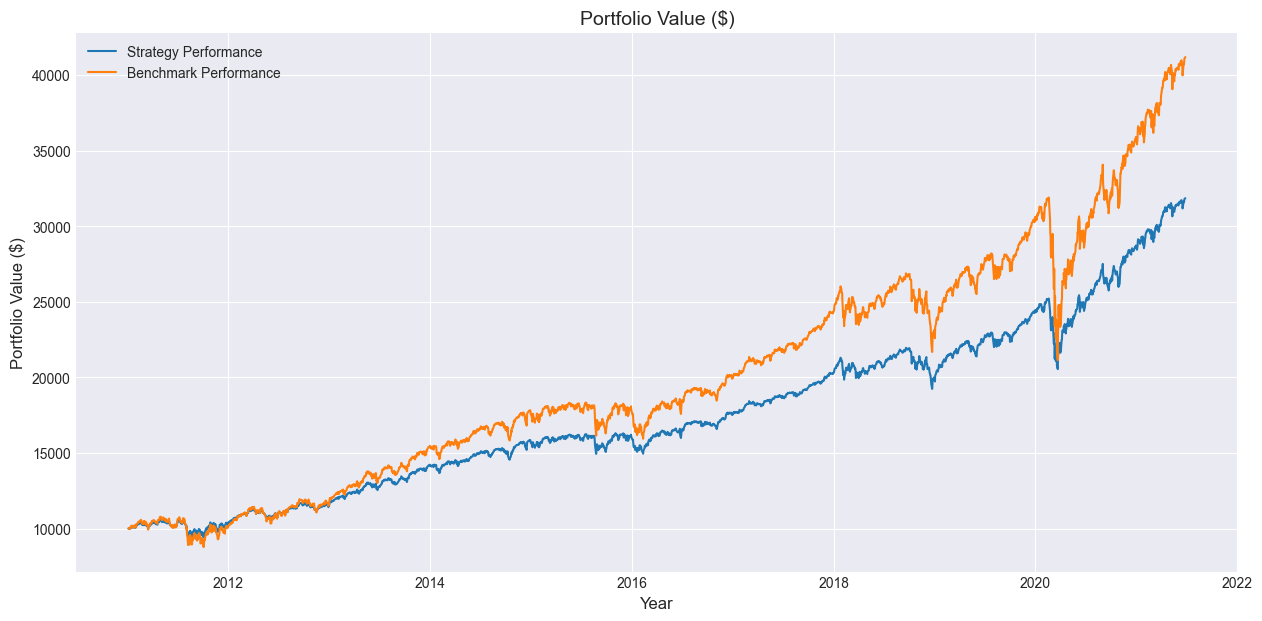

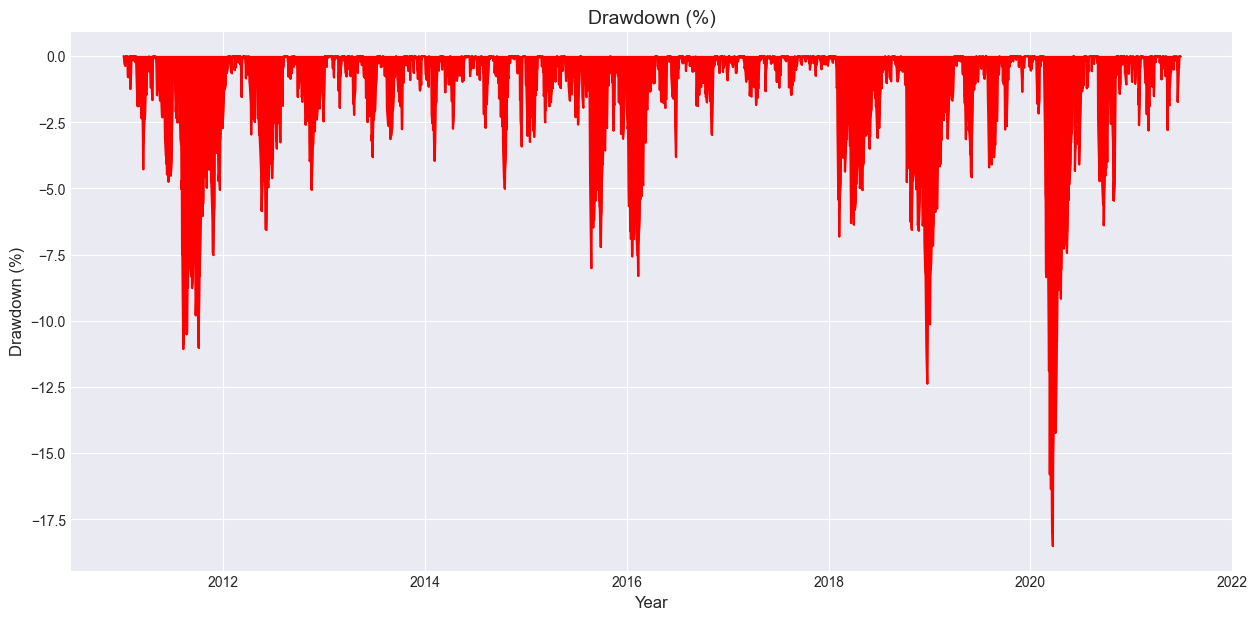

Total returns: 218.56%
Annualised returns (CAGR): 11.7%
Maximum drawdown (MDD): -18.51%
Return-to-MDD ratio: 0.63
Sharpe ratio: 0.07


In [7]:
# Run TIPP
returns_tipp = run_tipp(spy_2011_2021, m=multiplier,
                        floor_percent=floor_percent,
                        window=window,
                        initial_capital=initial_capital)

# Check strategy performance
performance_analysis(returns_tipp, initial_capital)

### Analysing TIPP with Volatility Targeting

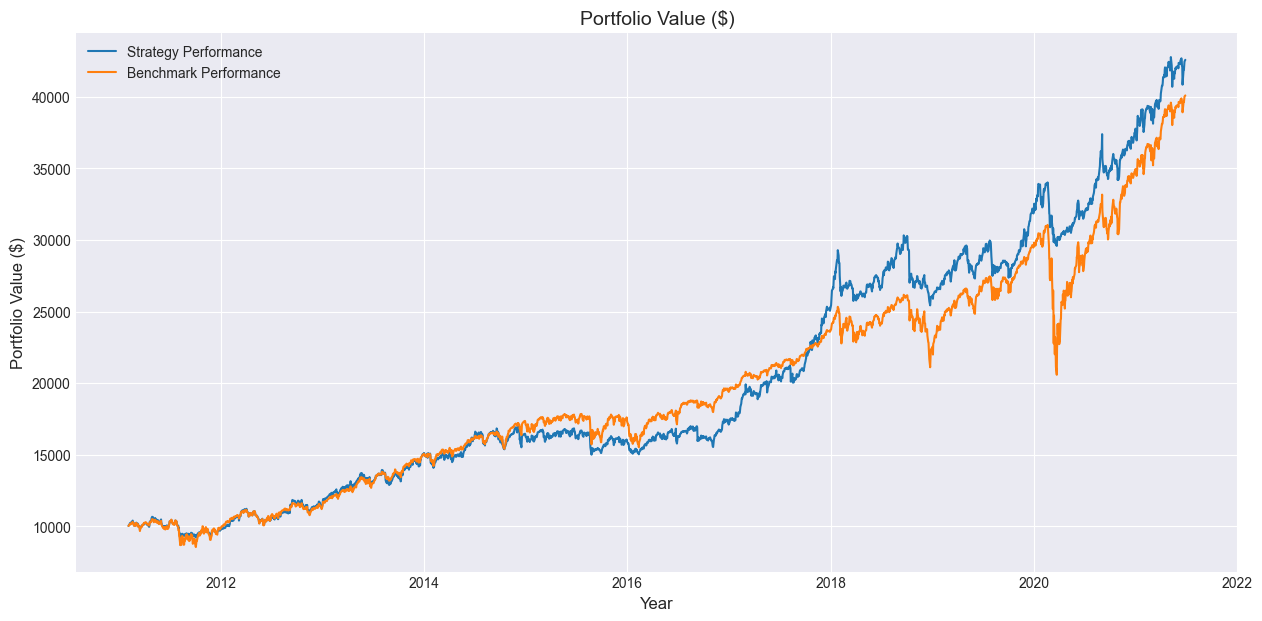

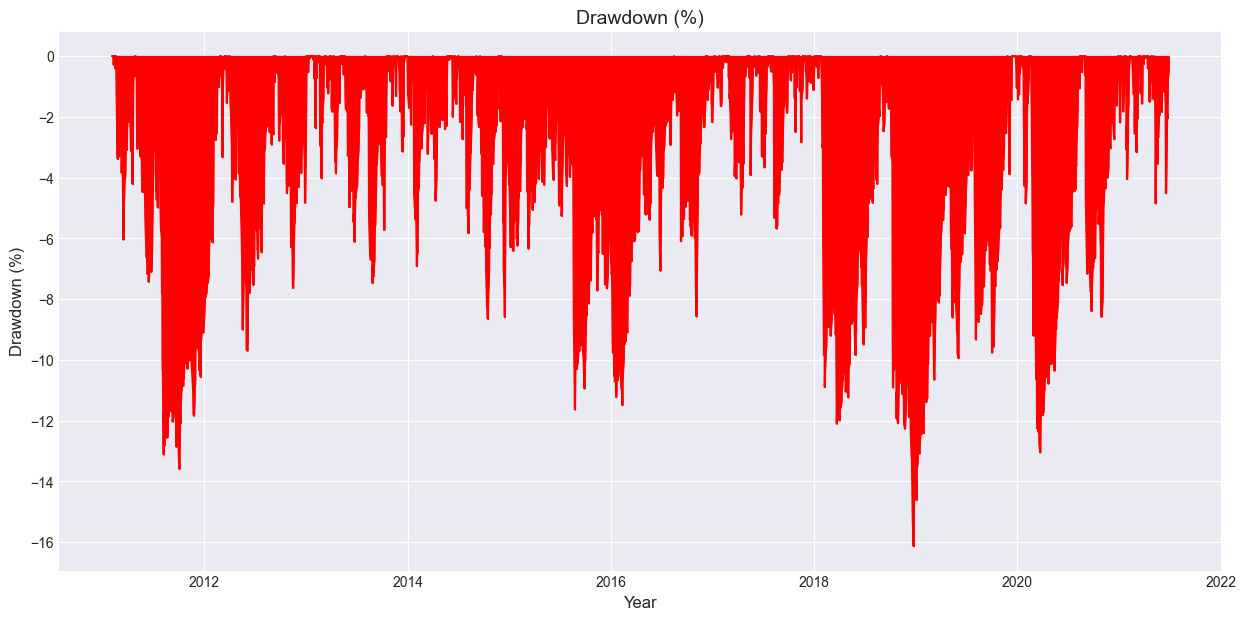

Total returns: 325.94%
Annualised returns (CAGR): 14.97%
Maximum drawdown (MDD): -16.13%
Return-to-MDD ratio: 0.93
Sharpe ratio: 0.07


In [8]:
# Run TIPP with Volatility Targeting
returns_tipp_vol = run_tipp_vol(spy_2011_2021, m=multiplier,
                                floor_percent=floor_percent,
                                volatility_target=volatility_target,
                                window=window,
                                leverage_cap=leverage_cap,
                                initial_capital=initial_capital)

# Check strategy performance
performance_analysis(returns_tipp_vol, initial_capital)

We will choose the model with the maximum return-to-MDD ratio since it will imply maximum return earned per unit of risk. By that logic, we should go with TIPP with Volatility Targeting.
This model solution can be used as a reference if you get stuck anywhere while building your own solution.<br><br>